In [9]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import shutil
import subprocess
import gc
import xarray as xr
import numpy as np
import pymp
import string

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset

# Initial setup

In [3]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory

scenario = ['/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK',
            '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK' ,
            '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK',
            '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK' ,
            '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK',
            '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK'
            ]

# scenario = ['/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK',
#             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK'
#             ]


# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    external_media = 'Joao_Macedo'
    model_path = f'/media/joao_macedo/{external_media}'

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False
melt_method = 'dry'
# melt_method = 'wet'

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

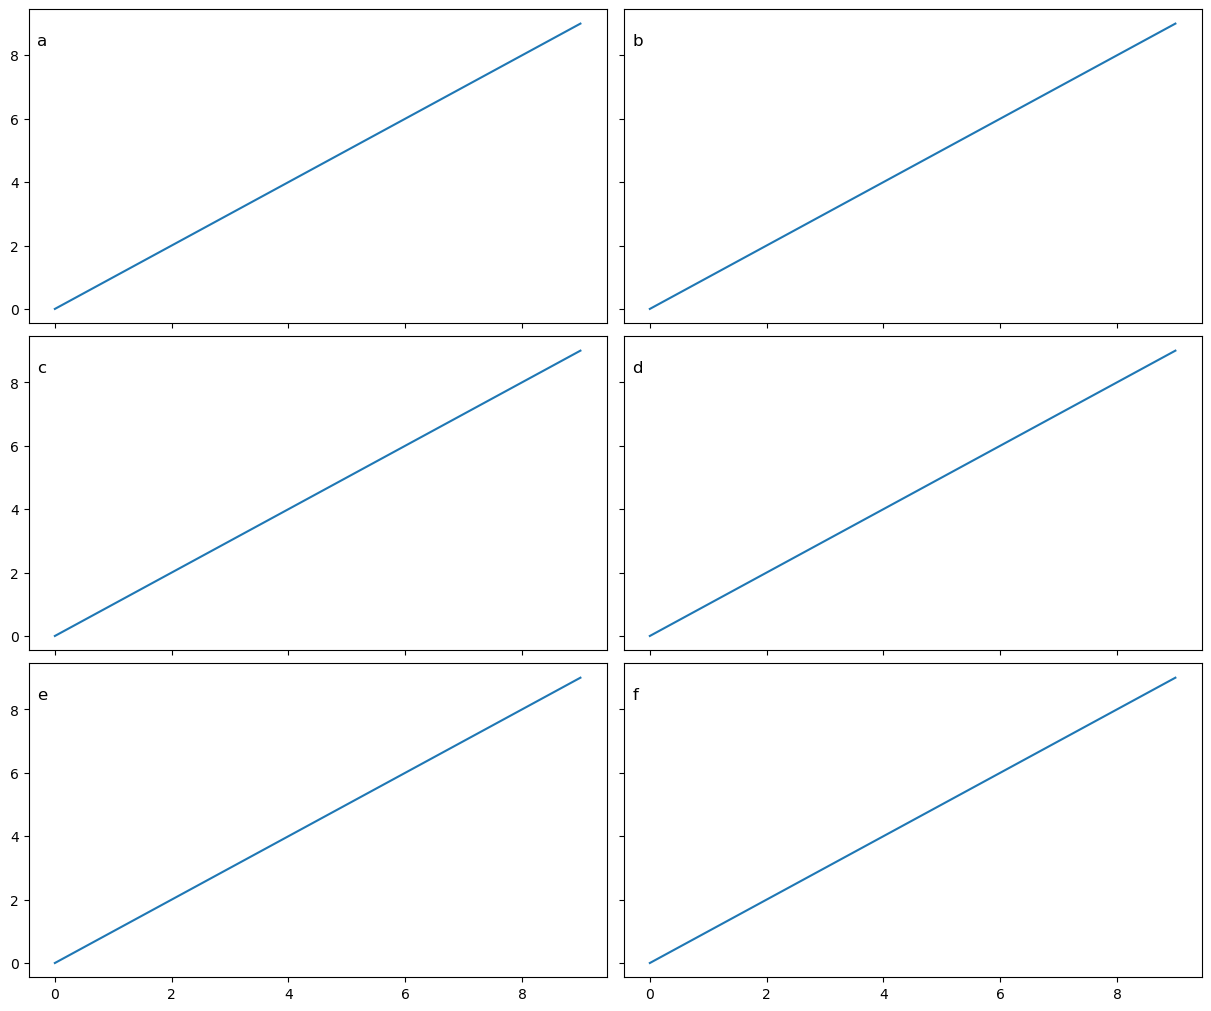

In [10]:
plt.close()
fig, axs = plt.subplots(3, 2, figsize=(12, 10), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(axs)]
fsize = 12
for ax, letter in zip(axs, letters):
    ax.plot(range(10), range(10))

    ax.text(0.015,
            0.90,
            letter,
            color='k',
            bbox=dict(edgecolor = 'white',
                        facecolor = 'white',
                        alpha = 0.6),
            fontsize=fsize,
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes,
            zorder=52)

In [24]:
# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc1_DT400_PT1437oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc10_DT400_PT1437oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK' #ok
scenario = '/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK' #ok
# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    # scenario = '/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK'
    external_media = 'Joao_Macedo'
    # model_path = f'/media/joao_macedo/{external_media}{scenario}'
    model_path = f'/Volumes/{external_media}{scenario}'

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False
melt_method = 'dry'
# melt_method = 'wet'

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
print(output_path)

if not os.path.isdir(output_path):
    os.makedirs(output_path)

model_name = os.path.split(model_path)[1]

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select with ones you would like to plot
#              'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
#              'strain',
             'strain_rate',
#              'temperature',
             'temperature_anomaly',
            #  'surface',
#              'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in properties):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        properties.remove('temperature')
        
if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in properties):
        properties.append('pressure')
    if ('temperature' not in properties):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    properties.remove('pressure')
    properties.remove('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

if(remove_density==True):
    properties.remove('density')

for dataset in datasets:
    if not os.path.isfile(f"{model_path}/_output_{dataset}.nc"):
        print(f"Could not find dataset {dataset}. Creating missing dataset.")
        ds_data = read_mandyoc_output(
            model_path,
            datasets=dataset,
            parameters_file="param.txt"
        )     

if (save_big_dataset):
    dataset = read_datasets(model_path, new_datasets, save_big_dataset = True) 
else:
    dataset = read_datasets(model_path, new_datasets)
# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset.data_vars:
    v_max = np.max((dataset.velocity_x**2 + dataset.velocity_z**2)**(0.5))    
    dataset.velocity_x[:] = dataset.velocity_x[:] / v_max
    dataset.velocity_z[:] = dataset.velocity_z[:] / v_max
print(dataset.info)

/Volumes/Joao_Macedo/Doutorado/cenarios/mandyoc/rifting/v1/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK/_output
<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (x: 1001, z: 301, time: 133)
Coordinates:
  * x            (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.98e+05 9.99e+05 1e+06
  * z            (z) float64 -3e+05 -2.99e+05 -2.98e+05 ... -2e+03 -1e+03 0.0
  * time         (time) float64 0.0 0.5 1.0 1.5 2.0 ... 39.17 39.37 39.59 39.83
    step         (time) int32 0 100 200 300 400 ... 12900 13000 13100 13200
Data variables:
    strain       (time, x, z) float64 ...
    density      (time, x, z) float64 ...
    strain_rate  (time, x, z) float64 ...
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                1001
    nz:                                301
    lx:                                1000000.0
    lz:                                300000.0
    multigrid:                         1
    s

In [25]:
len(dataset.step), dataset.step

(133,
 <xarray.DataArray 'step' (time: 133)>
 array([    0,   100,   200,   300,   400,   500,   600,   700,   800,
          900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
         1800,  1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,
         2700,  2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,
         3600,  3700,  3800,  3900,  4000,  4100,  4200,  4300,  4400,
         4500,  4600,  4700,  4800,  4900,  5000,  5100,  5200,  5300,
         5400,  5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,
         6300,  6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,
         7200,  7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,
         8100,  8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,
         9000,  9100,  9200,  9300,  9400,  9500,  9600,  9700,  9800,
         9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700,
        10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600,
        11700, 11800, 11900, 120

# Datasets handeling
## Model path

In [21]:
# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
print(output_path)

if not os.path.isdir(output_path):
    os.makedirs(output_path)

model_name = os.path.split(model_path)[1]

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select with ones you would like to plot
#              'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
#              'strain',
             'strain_rate',
#              'temperature',
             'temperature_anomaly',
            #  'surface',
#              'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in properties):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        properties.remove('temperature')
        
if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in properties):
        properties.append('pressure')
    if ('temperature' not in properties):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    properties.remove('pressure')
    properties.remove('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

if(remove_density==True):
    properties.remove('density')

for dataset in datasets:
    if not os.path.isfile(f"{model_path}/_output_{dataset}.nc"):
        print(f"Could not find dataset {dataset}. Creating missing dataset.")
        ds_data = read_mandyoc_output(
            model_path,
            datasets=dataset,
            parameters_file="param.txt"
        )     

if (save_big_dataset):
    dataset = read_datasets(model_path, new_datasets, save_big_dataset = True) 
else:
    dataset = read_datasets(model_path, new_datasets)
# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset.data_vars:
    v_max = np.max((dataset.velocity_x**2 + dataset.velocity_z**2)**(0.5))    
    dataset.velocity_x[:] = dataset.velocity_x[:] / v_max
    dataset.velocity_z[:] = dataset.velocity_z[:] / v_max
print(dataset.info)

/media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/stable/lit150km/crust40km/stable_DT350_lit150km_crust40km_HprodAst/_output
<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (x: 161, time: 134, z: 71)
Coordinates:
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 1.58e+06 1.59e+06 1.6e+06
  * time         (time) float64 0.0 4.563 8.714 13.71 ... 653.7 658.7 663.7
    step         (time) int32 0 1000 2000 3000 ... 130000 131000 132000 133000
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    strain       (time, x, z) float64 ...
    density      (time, x, z) float64 ...
    strain_rate  (time, x, z) float64 ...
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                161
    nz:                                71
    lx:                                1600000.0
    lz:                                700000.0
    multigrid:                         1
    solver:             

# Plot using pymp

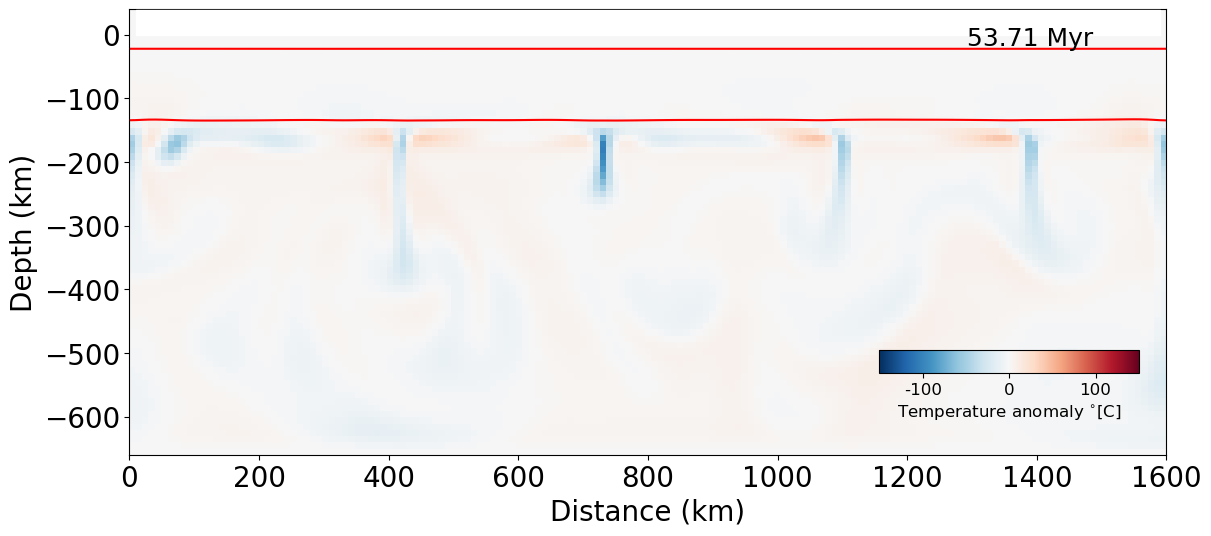

In [22]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 1#5

# start = 50
# end = 51
# step = 1

# step_initial = dataset.step[0]
# step_1 = dataset.step[1]
# step_final = dataset.step[-1]
# dstep = int(step_1 - step_initial)
with pymp.Parallel() as p:
    for i in p.range(start, end+step, step):
        # data = dataset.isel(time=i)
        per = np.round(100*(i+1-start)/(end-start), 2)
        text = f"Time: {np.round(float(dataset.isel(time=i).time), 2)} Myr; Step: {int(dataset.isel(time=i).step)}/{int(dataset.step.max())}, ({per:.2f}%)."
        
        # print(text, end='\r')
        
        for prop in properties:
    #         print(f"Handeling {prop}.", end='\n')
            if(prop != 'surface'): # you can customize
                xlims = [0, float(dataset.isel(time=i).lx) / 1.0e3]
                ylims = [-float(dataset.isel(time=i).lz) / 1.0e3 + 40, 40]
            else:
                xmin = 0 #+ 200
                xmax = float(dataset.isel(time=i).lx) / 1.0E3 #- 200
                xlims = [xmin, xmax]
                ylims = [-7, 7]
                
            single_plot(dataset.isel(time=i), prop, xlims, ylims, model_path, output_path, plot_isotherms=plot_isotherms, isotherms = [500, 1300], plot_melt=plot_melt, melt_method=melt_method)
            # single_plot(dataset.isel(time=i), prop, xlims, ylims, model_path, output_path, plot_isotherms=False, isotherms = [500, 1300])
    #     print((n+1)*'\033[F', end='')

# Making videos

In [23]:
fps = 30
    
for prop in properties:
    if(plot_melt):
        videoname = f'{model_path}/_output/{model_name}_{prop}_MeltFrac_{melt_method}'
    else:
        videoname = f'{model_path}/_output/{model_name}_{prop}'
        
    !rm {videoname}.mp4
    # !ffmpeg -r {fps} -f image2 -s 1920x1080 -pattern_type glob -i '{model_path}/_output/{model_name}_{prop}_*.png' -vcodec libx264 -crf 25 -pix_fmt yuv420p {model_path}/_output/{model_name}_{prop}.mp4
    !ffmpeg -r {fps} -f image2 -s 1920x1080 -pattern_type glob -i '{videoname}_*.png' -vcodec libx264 -vf 'pad=ceil(iw/2)*2:ceil(ih/2)*2' -r 24 -y -an -crf 25 -pix_fmt yuv420p {videoname}.mp4


rm: não foi possível remover '/media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/stable/lit150km/crust40km/stable_DT350_lit150km_crust40km_HprodAst/_output/stable_DT350_lit150km_crust40km_HprodAst_lithology.mp4': Arquivo ou diretório inexistente


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 12.2.0 (conda-forge gcc 12.2.0-19)
  configuration: --prefix=/home/joao_macedo/opt/anaconda3/envs/mpy --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-

# Converting videos to gifs

ss: skip seconds

t: duration time of the output

i: inputs format

vf: filtergraph (video filters)

    - fps: frames per second

    - scale: resize accordint to given pixels (e.g. 1080 = 1080p wide)
    
    - lanczos: scaling algorithm
    
    - palettegen and palette use: filters that generate a custom palette
    
    - split: filter that allows everything to be done in one command

loop: number of loops

    - 0: infinite

    - -1: no looping

    - for numbers n >= 0, create n+1 loops

In [24]:
# converting mp4 to gif
for prop in properties:
    if(plot_melt):
        gifname = f'{model_path}/_output/{model_name}_{prop}_MeltFrac_{melt_method}'
    else:
        gifname = f'{model_path}/_output/{model_name}_{prop}'
        
    !rm {gifname}.gif
    !ffmpeg -ss 0 -t 20 -i '{gifname}.mp4' -vf "fps=120,scale=1080:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 {gifname}.gif

rm: não foi possível remover '/media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/stable/lit150km/crust40km/stable_DT350_lit150km_crust40km_HprodAst/_output/stable_DT350_lit150km_crust40km_HprodAst_lithology.gif': Arquivo ou diretório inexistente


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 12.2.0 (conda-forge gcc 12.2.0-19)
  configuration: --prefix=/home/joao_macedo/opt/anaconda3/envs/mpy --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1685719756637/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-

# Zipping files

In [25]:
#zip plots, videos and gifs using external script zip_plots

script_path = f'/home/joao_macedo/opt/mandyoc-scripts/'
outputs_path = f'{model_path}/_output/'

script_name = 'zip_plots.sh'
script_path = os.path.join(script_path, script_name)

os.chdir(outputs_path)
last_folder = os.path.basename(os.path.normpath(outputs_path)) 
subprocess.run(["bash", script_path])

Zipping stable_DT350_lit150km_crust40km_HprodAst directory...
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_000000.png (deflated 28%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_001000.png

 (deflated 23%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_002000.png (deflated 23%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_003000.png (deflated 24%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_004000.png (deflated 24%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_005000.png (deflated 25%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_006000.png (deflated 25%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_007000.png (deflated 25%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_008000.png (deflated 25%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_009000.png (deflated 25%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_010000.png (deflated 25%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_011000.png (deflated 25%)
  adding: stable_DT350_lit150km_crust40km_HprodAst_lithology_012000.png (deflated 25%)
  adding: stable_DT350_lit1

CompletedProcess(args=['bash', '/home/joao_macedo/opt/mandyoc-scripts/zip_plots.sh'], returncode=0)

# Plot data - single core

In [ ]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 1#5

# start = 0
# end = 1
# step = 1

# step_initial = dataset.step[0]
# step_1 = dataset.step[1]
# step_final = dataset.step[-1]
# dstep = int(step_1 - step_initial)

for i in range(start, end+step, step):
    data = dataset.isel(time=i)
    per = np.round(100*(i+1-start)/(end-start), 2)
    text = f"Time: {np.round(float(data.time), 2)} Myr; Step: {int(data.step)}/{int(dataset.step.max())}, ({per:.2f}%)."
    
    print(text, end='\r')
    
    for prop in properties:
#         print(f"Handeling {prop}.", end='\n')
        if(prop != 'surface'): # you can customize
            xlims = [0, float(data.lx) / 1.0e3]
            ylims = [-float(data.lz) / 1.0e3 + 40, 40]
        else:
            xmin = 0 #+ 200
            xmax = float(data.lx) / 1.0E3 #- 200
            xlims = [xmin, xmax]
            ylims = [-7, 7]
            
        single_plot(data, prop, xlims, ylims, model_path, output_path, plot_isotherms=True, isotherms = [500, 1300])
        # single_plot(data, prop, xlims, ylims, model_path, output_path, plot_isotherms=False, isotherms = [500, 1300])
#     print((n+1)*'\033[F', end='')